In [120]:
#Optimum filter V1.1, adapt to the case where the trace length is longer than the template
import numpy as np
from numpy.fft import rfft, irfft, fft, ifft, fftfreq, rfftfreq
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import fftconvolve


class OptimumFilter():
    
    def __init__(self, template, noise_psd, sampling_frequency):
        self._template = template
        self._noise_psd = noise_psd
        self._sampling_frequency = sampling_frequency
        self._update_state()
        
    def set_template(self, template):
        self._template = template
        self._update_state()
        
    def set_noise_psd(self, noise_psd):
        self._noise_psd = noise_psd
        self._update_state()
        
    def _update_state(self):
        self._length = len(self._template)
        
        if self._length%2==0:
            self._noise_psd_unfolded = np.concatenate(([np.inf],
                                                       self._noise_psd[1:-1]/2,
                                                       [self._noise_psd[-1]],
                                                       self._noise_psd[-2:0:-1]/2))
        else:
            self._noise_psd_unfolded = np.concatenate(([np.inf],
                                                       self._noise_psd[1:]/2,
                                                       self._noise_psd[-1:0:-1]/2))
            
        self._template_fft = fft(self._template)/self._sampling_frequency
        
        self._kernel_fft = self._template_fft.conjugate() / self._noise_psd_unfolded
        self._kernel_normalization = np.real(np.dot(self._kernel_fft, self._template_fft))*self._sampling_frequency/self._length 
        self._filter_kernel = self._kernel_fft / self._kernel_normalization
        self._kernel_td = np.real(ifft(self._filter_kernel)) * self._sampling_frequency
        
        
    def fit(self, trace):
        trace_fft = fft(trace, axis=-1)/self._sampling_frequency # V
        trace_filtered = self._filter_kernel * trace_fft
        amp = np.real(trace_filtered.sum(axis=-1)) * self._sampling_frequency / self._length
        chisq0 = np.real((trace_fft.conj() * trace_fft / self._noise_psd_unfolded).sum()) * self._sampling_frequency / self._length
        chisq = (chisq0 - amp**2 * self._kernel_normalization) / (self._length - 2) 
        
        return amp, chisq
    
    def fit_with_shift(self, trace, allowed_shift_range=None):
 
        trace_fft = fft(trace, axis=-1)/self._sampling_frequency # V
        trace_filtered = self._filter_kernel * trace_fft
        trace_filtered_td = np.real(
            ifft(trace_filtered, axis=-1)
        ) * self._sampling_frequency

        chi0 = np.real((trace_fft.conj() * trace_fft / self._noise_psd_unfolded).sum()) * self._sampling_frequency / self._length
        chit_withdelay = (trace_filtered_td ** 2) * self._kernel_normalization
        chi = chi0 - chit_withdelay
        
        if allowed_shift_range is None:
            ind = np.arange(len(chi))
        else:
            ind = np.concatenate((np.arange(self._length+allowed_shift_range[0], self._length),
                                  np.arange(allowed_shift_range[1]+1)))
        
        best_ind = ind[np.argmin(chi[ind], axis=-1)]
        
        amp = trace_filtered_td[best_ind]
        chisq = chi[best_ind]/(self._length-3)
        t0 = best_ind if best_ind<self._length//2 else best_ind-self._length
        
        return amp, chisq, t0, trace_filtered_td

    def rolling_fit_with_shift(self, trace_long, allowed_shift_range=[0, 32767]):
        L = len(trace_long)
        N = self._length
        fs = self._sampling_frequency

        n_windows = L // N
        amps = np.zeros(n_windows)
        chisqs = np.zeros(n_windows)
        shifts = np.zeros(n_windows, dtype=int)
        positions = np.zeros(n_windows, dtype=int)

        for i in range(n_windows):
            start = i * N
            segment = trace_long[start:start + N]
            amp, chisq, t0 = self.fit_with_shift(segment, allowed_shift_range)

            amps[i] = amp
            chisqs[i] = chisq
            shifts[i] = t0
            positions[i] = start + t0

        return amps, chisqs, shifts, positions
    
    
    def convolve_long_trace(self, trace_long):

        filtered_trace = fftconvolve(trace_long, self._kernel_td[::-1], mode='valid')
        return filtered_trace


In [121]:
import yaml
import numpy as np
import zstandard as zstd
import os
from TraceSimulator import TraceSimulator


import matplotlib.pyplot as plt
def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict
sampling_frequency = 3906250
vac_template = np.load("templates/vac_ch_template.npy")
sub_template = np.load("templates/sub_ch_template.npy")
noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")



In [122]:
sub_of = OptimumFilter(sub_template, noise_psd, sampling_frequency)

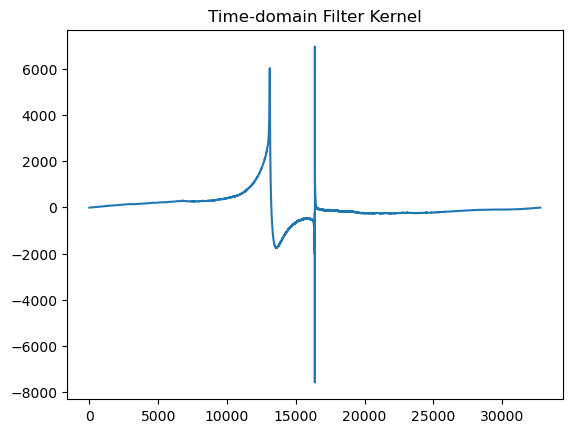

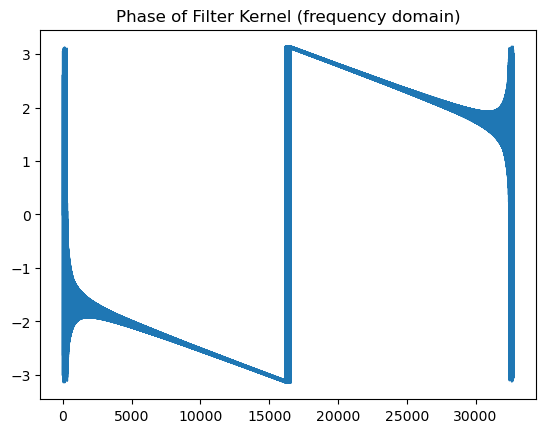

In [88]:
kernel_td = sub_of.get_filter_kernel_time()
kernel_freq = sub_of.get_filter_kernel_freq()

plt.plot(kernel_td)
plt.title("Time-domain Filter Kernel")
plt.show()

plt.plot(np.angle(kernel_freq))
plt.title("Phase of Filter Kernel (frequency domain)")
plt.show()


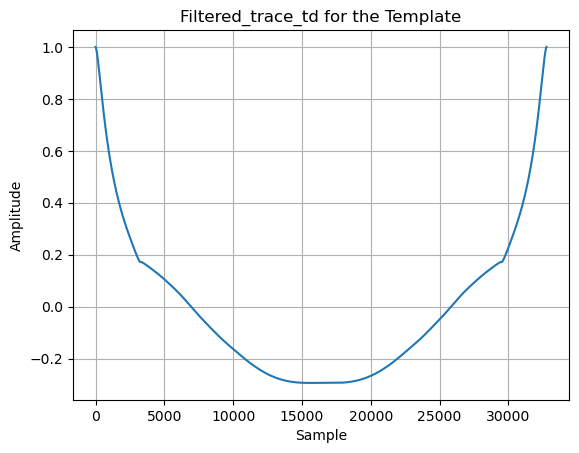

In [127]:
amp, chisq, t0, trace_filtered_td = sub_of.fit_with_shift(sub_template)
plt.plot(trace_filtered_td)
plt.title("Filtered_trace_td for the Template")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [124]:
amp

1.0000000000000002

In [125]:
chisq

-1.3553768040594005e-20

In [126]:
t0

0